## Data Cleaning & Preparation

In [45]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from langdetect import detect

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        # Get all CSV files in the source folder
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"\n\nFound {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                # Load the dataset
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"\nProcessing file: {file_path} with {reviews.shape[0]} rows")
                
                # Check if the required columns are present
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                # Remove missing values
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                # Normalize ratings to a common scale (0 to 1)
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                # Language detection and filtering for English reviews
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                # Remove duplicates
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                # Text preprocessing: convert to lowercase, remove punctuation, remove stopwords, and lemmatize
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                # Append to the list of all reviews
                all_reviews.append(reviews)

    # Combine all reviews into a single DataFrame
    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Prepare labels
    labels = combined_reviews['Review Score'].values

    # Split data into training and testing sets (70/30)
    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

    # Save the preprocessed and vectorized dataset along with indices
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, x_test_indices=np.arange(len(x_test)))

    # Variable Identification
    x = combined_reviews['Review Content']
    y_ground_truth = combined_reviews['Review Score']

    # Vectorization using Word2Vec
    sentences = [review.split() for review in x]
    word2vec_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

    # Generate word vectors with consistent lengths
    x_vectorized = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv] or [np.zeros(EMBEDDING_DIM)], axis=0) for review in x])
    
    # Vectorization using Doc2Vec
    tagged_data = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(x)]
    doc2vec_model = Doc2Vec(tagged_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
    x_doc2vec = np.array([doc2vec_model.infer_vector(review.split()) for review in x])

    # Normalize sentiment labels (y)
    y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    # Sentiment Label Preprocessing
    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    # Add sentiment labels to the DataFrame for clarity
    combined_reviews['Sentiment Label'] = y_labels

    # Save preprocessed variables
    np.savez_compressed(output_path, 
                    x_train=x_train, 
                    x_test=x_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    y_labels=y_labels,  # Ensure this line is present
                    x_test_indices=np.arange(len(x_test)))

    # Verify shapes
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_vectorized shape: {x_vectorized.shape}")
    print(f"x_doc2vec shape: {x_doc2vec.shape}")
    print(f"y_labels shape: {y_labels.shape}")
    

# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    # Mapping hotel names to numbered output folder names
    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        print(f"Processing {hotel_name} reviews...")
        process_reviews(hotel_name, source_folders, output_folder)
        print(f"Finished processing {hotel_name} reviews.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing bai_hotel reviews...


Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel

Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 1767 rows
After removing duplicates: 1752 rows
After text preprocessing: 1752 rows


Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel

Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 662 rows
After removing duplicates: 657 rows
After text preprocessing: 657 rows


Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel

Processing file: ..\raw data\klook_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 114 rows
After dropping missing values: 114 rows
After normalizing ratings: 114 rows
After filteri

## EDA

In [46]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the base path for datasets
# base_output_path = os.path.join('..', 'datasets')

# # List of hotel folders and their corresponding names for the EDA plots
# hotel_folders = {
#     '1_bai_hotel': 'bai_hotel',
#     '2_dusit_thani_mactan': 'dusit_thani_mactan',
#     '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
#     '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
#     '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
#     '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
# }

# for folder, hotel_name in hotel_folders.items():
#     output_folder = os.path.join(base_output_path, folder)
    
#     # Load the preprocessed data
#     data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
#     data = np.load(data_path)
    
#     x_train = data['x_train']
#     x_test = data['x_test']
#     y_train = data['y_train']
#     y_test = data['y_test']
    
#     # For EDA purposes only
#     # Review lengths
#     review_lengths = [len(review) for review in x_train]
#     plt.hist(review_lengths, bins=50)
#     plt.title(f'{hotel_name} Review Lengths')
#     plt.xlabel('Review Length (in words)')
#     plt.ylabel('Frequency')
#     plt.show()
    
#     # Distribution of Ratings in Training Data
#     plt.hist(y_train, bins=10, edgecolor='k')
#     plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
#     plt.xlabel("Rating")
#     plt.ylabel("Frequency")
#     plt.show()
    
#     # Distribution of Sentiment Scores
#     plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
#     plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
#     plt.legend(loc='upper right')
#     plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
#     plt.xlabel('Sentiment Score')
#     plt.ylabel('Frequency')
#     plt.show()

# Checking of OG negative counts

In [47]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and check sentiment labels
def check_sentiment_labels(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"  # Adjust path as needed
        data = np.load(data_path)

        y_labels = data['y_labels']  # Load sentiment labels

        # Check unique values and count of negative labels
        print(f"Hotel: {hotel_name}")
        print(f"y_labels unique values: {np.unique(y_labels)}")
        print(f"Number of negative labels (should be -1): {np.sum(y_labels == -1)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Check sentiment labels for each hotel
for hotel in hotels:
    check_sentiment_labels(hotel)


Hotel: bai_hotel
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 82
--------------------------------------------------
Hotel: dusit_thani_mactan
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 118
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 8
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 29
--------------------------------------------------
Hotel: seda_ayala_center_cebu
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 53
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 91
--------------------------------------------------


## Positive & Negative Counts
#### to test for overfitting or underfitting check

In [48]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels
def count_sentiments(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)

        y_labels = data['y_labels']  # Assuming y_labels contains sentiment labels

        positive_count = np.sum(y_labels == 1)
        negative_count = np.sum(y_labels == -1)
        neutral_count = np.sum(y_labels == 0)

        print(f"Hotel: {hotel_name}")
        print(f"Positive reviews: {positive_count}")
        print(f"Negative reviews: {negative_count}")
        print(f"Neutral reviews: {neutral_count}")
        print(f"Total reviews: {len(y_labels)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Count and display sentiments for each hotel
for hotel in hotels:
    count_sentiments(hotel)

Hotel: bai_hotel
Positive reviews: 3477
Negative reviews: 82
Neutral reviews: 294
Total reviews: 3853
--------------------------------------------------
Hotel: dusit_thani_mactan
Positive reviews: 1394
Negative reviews: 118
Neutral reviews: 318
Total reviews: 1830
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
Positive reviews: 49
Negative reviews: 8
Neutral reviews: 7
Total reviews: 64
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
Positive reviews: 404
Negative reviews: 29
Neutral reviews: 91
Total reviews: 524
--------------------------------------------------
Hotel: seda_ayala_center_cebu
Positive reviews: 1565
Negative reviews: 53
Neutral reviews: 267
Total reviews: 1885
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
Positive reviews: 1062
Negative reviews: 91
Neutral reviews: 421
Total reviews: 1574
--------------------------------------------------


# --- CLASS IMBALANCE ---  
### - Solution:
####    Augment data (negatives only)

# Data Augmentation for Negative Reviews

In [73]:
import os
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
AUGMENTATION_FACTOR = 5

# Augmentation function
def augment_review(review, num_augments=5):
    words = word_tokenize(review)
    augmented_reviews = []
    for _ in range(num_augments):
        new_review = []
        for word in words:
            if word in stopwords.words('english'):
                new_review.append(word)
            else:
                synonyms = wordnet.synsets(word)
                if synonyms:
                    synonym = synonyms[0].lemmas()[0].name()
                    new_review.append(synonym)
                else:
                    new_review.append(word)
        augmented_reviews.append(' '.join(new_review))
    return augmented_reviews

# Augment and save data
def augment_and_save_data(hotel_name, original_folder_path, augmented_folder_path):
    # Load the original data
    data_path = os.path.join(original_folder_path, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    x_train = data['x_train']
    y_labels = data['y_labels']  # Use y_labels to identify sentiment

    # Ensure the output directory exists
    os.makedirs(augmented_folder_path, exist_ok=True)

    # Identify negative reviews
    negative_indices = np.nonzero(y_labels == -1)[0]
    print(f"Total original negative reviews found: {len(negative_indices)}")

    if len(negative_indices) == 0:
        print(f"No negative reviews to augment for {hotel_name}. Skipping augmentation.")
        return

    # Augment negative reviews
    augmented_reviews = []
    augmented_labels = []

    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts([" ".join(map(str, seq)) for seq in x_train])

    # Ensure that indices are within bounds
    negative_indices = [index for index in negative_indices if index < len(x_train)]

    if len(negative_indices) == 0:
        print(f"No valid negative review indices to augment for {hotel_name}.")
        return

    for index in negative_indices:
        original_sequence = x_train[index]
        original_review = " ".join([tokenizer.index_word.get(i, "[UNK]") for i in original_sequence if i != 0])
        new_reviews = augment_review(original_review, AUGMENTATION_FACTOR)

        augmented_reviews.extend(new_reviews)
        augmented_labels.extend([-1] * len(new_reviews))

    # Convert augmented reviews to sequences and pad them
    augmented_sequences = tokenizer.texts_to_sequences(augmented_reviews)
    augmented_sequences_padded = pad_sequences(augmented_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Debug: Print out the shapes before concatenation
    print(f"x_train shape before augmentation: {x_train.shape}")
    print(f"augmented_sequences_padded shape: {augmented_sequences_padded.shape}")
    print(f"y_labels shape before augmentation: {y_labels.shape}")
    print(f"augmented_labels length: {len(augmented_labels)}")

    x_train_augmented = np.concatenate([x_train, augmented_sequences_padded], axis=0)
    y_labels_augmented = np.concatenate([y_labels, np.array(augmented_labels)], axis=0)

    # Debug: Check lengths after concatenation
    print(f"x_train_augmented shape: {x_train_augmented.shape}")
    print(f"y_labels_augmented shape: {y_labels_augmented.shape}")

    if len(x_train_augmented) != len(y_labels_augmented):
        raise ValueError(f"Inconsistent lengths after augmentation: {len(x_train_augmented)} samples in x_train, {len(y_labels_augmented)} labels in y_labels.")

    output_path = os.path.join(augmented_folder_path, f"{hotel_name}_augmented_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train_augmented, y_labels=y_labels_augmented)

    print(f"Saved augmented data for {hotel_name} with {x_train_augmented.shape[0]} training reviews.")

# Define source and output folders using relative paths
def main():
    hotel_folder_mapping = {
        'bai_hotel': '1_bai_hotel',
        'dusit_thani_mactan': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
    }
    
    base_folder_path = '../datasets'
    augmented_base_folder_path = '../augmented_datasets'

    for hotel in hotel_folder_mapping:
        print(f"Processing {hotel}...")
        original_folder_path = os.path.join(base_folder_path, hotel_folder_mapping[hotel])
        augmented_folder_path = os.path.join(augmented_base_folder_path, hotel_folder_mapping[hotel])
        augment_and_save_data(hotel, original_folder_path, augmented_folder_path)

if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing bai_hotel...
Total original negative reviews found: 82


ValueError: Inconsistent lengths after augmentation: 2957 samples in x_train, 4113 labels in y_labels.

In [68]:
# Function to load and check sentiment labels
def check_sentiment_labels(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"  # Adjust path as needed
        data = np.load(data_path)

        y_labels = data['y_labels']  # Load sentiment labels

        # Check unique values and count of negative labels
        print(f"Hotel: {hotel_name}")
        print(f"y_labels unique values: {np.unique(y_labels)}")
        print(f"Number of negative labels (should be -1): {np.sum(y_labels == -1)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Check sentiment labels for each hotel
for hotel in hotels:
    check_sentiment_labels(hotel)

Hotel: bai_hotel
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 342
--------------------------------------------------
Hotel: dusit_thani_mactan
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 533
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 33
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 54
--------------------------------------------------
Hotel: seda_ayala_center_cebu
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 178
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
y_labels unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 271
--------------------------------------------------


# Comparison of reviews OG VS Augmented

In [69]:
import numpy as np
import pandas as pd

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels
def count_sentiments(hotel_name, folder_type='original'):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        if folder_type == 'original':
            data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        elif folder_type == 'augmented':
            data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"
        else:
            raise ValueError("Invalid folder_type. Choose 'original' or 'augmented'.")

        data = np.load(data_path)
        y_labels = data['y_labels']

        positive_count = np.sum(y_labels == 1)
        negative_count = np.sum(y_labels == -1)
        neutral_count = np.sum(y_labels == 0)
        total_reviews = len(y_labels)

        return positive_count, negative_count, neutral_count, total_reviews

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None, None, None, None

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Prepare a DataFrame to store the results
columns = ['Hotel', 'Positive (Original)', 'Negative (Original)', 'Neutral (Original)', 'Total (Original)',
           'Positive (Augmented)', 'Negative (Augmented)', 'Neutral (Augmented)', 'Total (Augmented)']
results_df = pd.DataFrame(columns=columns)

# Count and store sentiments for each hotel
for hotel in hotels:
    original_counts = count_sentiments(hotel, folder_type='original')
    augmented_counts = count_sentiments(hotel, folder_type='augmented')

    if original_counts[0] is not None and augmented_counts[0] is not None:
        # Create a DataFrame for the current hotel's counts
        hotel_df = pd.DataFrame({
            'Hotel': [hotel],
            'Positive (Original)': [original_counts[0]],
            'Negative (Original)': [original_counts[1]],
            'Neutral (Original)': [original_counts[2]],
            'Total (Original)': [original_counts[3]],
            'Positive (Augmented)': [augmented_counts[0]],
            'Negative (Augmented)': [augmented_counts[1]],
            'Neutral (Augmented)': [augmented_counts[2]],
            'Total (Augmented)': [augmented_counts[3]],
        })
        # Concatenate the hotel_df to results_df
        results_df = pd.concat([results_df, hotel_df], ignore_index=True)

results_df


,Hotel,Positive (Original),Negative (Original),Neutral (Original),Total (Original),Positive (Augmented),Negative (Augmented),Neutral (Augmented),Total (Augmented)
0,bai_hotel,3477,82,294,3853,3477,342,294,4113
1,dusit_thani_mactan,1394,118,318,1830,1394,533,318,2245
2,fairfield_by_marriott_cebu,49,8,7,64,49,33,7,89
3,jpark_island_resort_and_waterpark,404,29,91,524,404,54,91,549
4,seda_ayala_center_cebu,1565,53,267,1885,1565,178,267,2010
5,waterfront_hotel_and_casino,1062,91,421,1574,1062,271,421,1754


# General Sentiment Analysis

In [71]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Load preprocessed data for a single hotel
def load_data(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"
        data = np.load(data_path)
        
        # List all the keys in the file to see what's available
        print(f"Keys in {hotel_name} data: {list(data.keys())}")
        
        x_train = data['x_train']
        y_labels = data['y_labels']
        
        if 'x_test' not in data or 'y_train' not in data or 'y_test' not in data:
            # Split the data into training and testing sets (70/30)
            x_train, x_test, y_train, y_test = train_test_split(x_train, y_labels, test_size=0.3, random_state=42)
            
            # Save the newly split data into the file
            np.savez_compressed(data_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, y_labels=y_labels)
            print(f"Data re-split and saved for {hotel_name}.")
        else:
            x_train = data['x_train']
            x_test = data['x_test']
            y_train = data['y_train']
            y_test = data['y_test']
        
        return x_train, x_test, y_train, y_test
    
    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None, None, None, None

# Train and evaluate the model for a single hotel
def train_and_evaluate_model(x_train, x_test, y_train, y_test, label):
    try:
        input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
        conv1d = Conv1D(128, 5, activation='relu')(embedding)
        maxpool = MaxPooling1D(2)(conv1d)
        bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
        dropout = Dropout(0.5)(bi_lstm)
        flat = Flatten()(dropout)
        output = Dense(1, activation='sigmoid')(flat)
        model = Model(inputs=input_text, outputs=output)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"\n\n\nTraining the CNN-biLSTM model for {label}...")
        
        # Calculate class weights
        class_weights = {0: len(y_train) / (2 * np.bincount(y_train == 0)[0]), 
                        1: len(y_train) / (2 * np.bincount(y_train == 1)[1])}

        # Train the model with class weights
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, class_weight=class_weights)

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Training and Validation Accuracy for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training and Validation Loss for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss for {label}: {loss}")
        print(f"Test Accuracy for {label}: {accuracy}")

        y_pred_prob = model.predict(x_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Ensure y_test is binary for classification report
        y_test_binary = (y_test > 0.5).astype(int)

        print(f"\nClassification Report for {label}:")
        print(classification_report(y_test_binary, y_pred, target_names=['Negative', 'Positive']))

        conf_matrix = confusion_matrix(y_test_binary, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        # Evaluate regression metrics for continuous predictions
        mse = mean_squared_error(y_test, y_pred_prob)
        print(f"Mean Squared Error for {label}: {mse}")

        # Save and print the predicted sentiment values
        output_folder = f"../predictions/{hotel_folder_mapping[label.split()[1]]}"
        os.makedirs(output_folder, exist_ok=True)
        np.savez_compressed(os.path.join(output_folder, f"{label}_predictions.npz"), y_pred_prob=y_pred_prob)
        print(f"Predicted sentiment values for {label} saved in {output_folder}")

    except Exception as e:
        print(f"Error during training and evaluation for {label}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Perform sentiment analysis for each hotel
for hotel in hotels:
    x_train, x_test, y_train, y_test = load_data(hotel)
    if x_train is not None and x_test is not None:
        train_and_evaluate_model(x_train, x_test, y_train, y_test, f'Hotel {hotel}')
    else:
        print(f"Skipping sentiment analysis for {hotel} due to data loading error.")



Keys in bai_hotel data: ['x_train', 'y_labels']
Error loading data for bai_hotel: Found input variables with inconsistent numbers of samples: [2957, 4113]
Skipping sentiment analysis for bai_hotel due to data loading error.
Keys in dusit_thani_mactan data: ['x_train', 'y_labels']
Error loading data for dusit_thani_mactan: Found input variables with inconsistent numbers of samples: [1696, 2245]
Skipping sentiment analysis for dusit_thani_mactan due to data loading error.
Keys in fairfield_by_marriott_cebu data: ['x_train', 'y_labels']
Error loading data for fairfield_by_marriott_cebu: Found input variables with inconsistent numbers of samples: [69, 89]
Skipping sentiment analysis for fairfield_by_marriott_cebu due to data loading error.
Keys in jpark_island_resort_and_waterpark data: ['x_train', 'y_labels']
Error loading data for jpark_island_resort_and_waterpark: Found input variables with inconsistent numbers of samples: [391, 549]
Skipping sentiment analysis for jpark_island_resort_a

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading of predicted values

In [ ]:
import numpy as np
import os

# List of hotels and their respective folders
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and print predicted values
def load_and_print_predictions(hotel_name):
    folder_name = hotel_folder_mapping[hotel_name]
    prediction_path = f"../predictions/{folder_name}/Hotel {hotel_name}_predictions.npz"
    
    try:
        data = np.load(prediction_path)
        y_pred_prob = data['y_pred_prob']
        print(f"Predicted sentiment values for {hotel_name}:\n{y_pred_prob}")
    except Exception as e:
        print(f"Error loading predictions for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Load and print predictions for each hotel
for hotel in hotels:
    load_and_print_predictions(hotel)
    
#* NOTE: these are the predicted sentiment value of EACH review

Predicted sentiment values for bai_hotel:
[[0.93573856]
 [0.6786188 ]
 [0.9934087 ]
 ...
 [0.9995678 ]
 [0.9994022 ]
 [0.99158883]]
Predicted sentiment values for dusit_thani_mactan:
[[0.6854444 ]
 [0.9699294 ]
 [0.9999594 ]
 [0.937049  ]
 [0.99996316]
 [0.95692   ]
 [0.9311055 ]
 [0.76565385]
 [0.7301127 ]
 [0.81026214]
 [0.9950801 ]
 [0.9705549 ]
 [0.9910242 ]
 [0.89236635]
 [0.8846637 ]
 [0.96449935]
 [0.82075226]
 [0.697083  ]
 [0.9999481 ]
 [0.98273057]
 [0.99861753]
 [0.9992071 ]
 [0.9823408 ]
 [0.65223825]
 [0.9662854 ]
 [0.99839556]
 [0.8920047 ]
 [0.9954724 ]
 [0.6978602 ]
 [0.856033  ]
 [0.9996968 ]
 [0.9774231 ]
 [0.9694008 ]
 [0.9964098 ]
 [0.9789319 ]
 [0.91150534]
 [0.9983429 ]
 [0.99993473]
 [0.8619333 ]
 [0.81097263]
 [0.91965634]
 [0.45881984]
 [0.5686474 ]
 [0.8243907 ]
 [0.9960591 ]
 [0.9998253 ]
 [0.79023135]
 [0.8999032 ]
 [0.7133308 ]
 [0.96646535]
 [0.63010687]
 [0.69051194]
 [0.56314266]
 [0.57532454]
 [0.9999589 ]
 [0.9216146 ]
 [0.99996513]
 [0.9999484 ]
 [0.9

# Aspect-based Sentiment Analysis

In [ ]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Index(['Opinion', 'Labels'], dtype='object')
Training the Aspect-Based Analysis model...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2530 - loss: 4.6521 - val_accuracy: 0.4785 - val_loss: 5.5421
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4162 - loss: 5.7795 - val_accuracy: 0.4785 - val_loss: 5.9801
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3150 - loss: 6.1675 - val_accuracy: 0.0993 - val_loss: 6.3393
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2994 - loss: 6.4041 - val_accuracy: 0.0993 - val_loss: 6.7507
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2733 - loss: 6.6940 - val_accuracy: 0.4785 - val_loss: 7.0802
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3462 - loss: 7.3290 - val_accuracy: 0.4785 - val_loss: 7.5129
Epoch 7/10
 37/170 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4698 - loss: 7.6051

KeyboardInterrupt: 

## KDE for each hotel

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


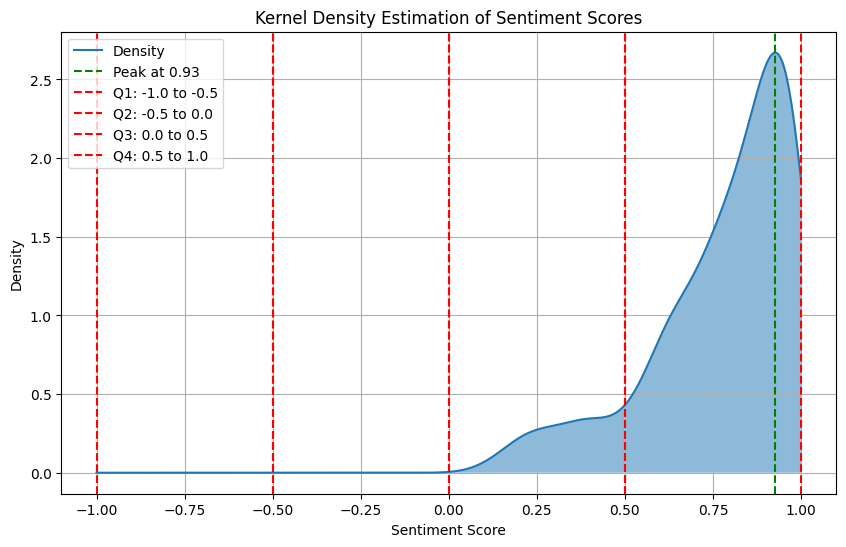

Peak value: 0.93
Quartiles: [(-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0)]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

In [ ]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 1.8867376e-11, 'Comfort & Facilities': 29.187944, 'Food': 35.120018, 'Internet': 0.0, 'Location': 5.216267, 'Staff': 30.139652, 'Value for money': 0.33602843}


,Aspect,Percentage Likelihood
3,Food,3.512002e+01
6,Staff,3.013965e+01
2,Comfort & Facilities,2.918794e+01
5,Location,5.216267e+00
7,Value for money,3.360284e-01
1,Cleanliness,1.886738e-11
0,,0.000000e+00
4,Internet,0.000000e+00
